# Homework  I - Digital Epidemiology

## Wikipedia Usage Estimates Prevalence of Influenza in Italy

#### Alessia Galli, Andrea Di Luca, Riccardo Gobbo

Keeping the circulation level of the flu under control requires constant monitoring. With the development of technology and its use, it is now possible to guarantee, or at least to provide, a system for estimating, in near real time, the level of infectious disease such as influenza. As discussed in the analysis "Wikipedia Usage Estimates Prevalence of Influenza-Like Illness in the United States in Near Real-Time" by David J Mclver and John S. Brownstein, our investigation also aims to perform the same type of analysis by estimating the propagation of influenza, but in Italy through the Italian Wikipedia portal. The number of daily views of some Wikipedia articles on influenza, health, medications for fever and vaccines in the period between July 2015 and December 2018 are collected. These data were then compared with the official levels of influenza activity provided by Influnet, a surveillance system coordinated by the Istituto Superiore di Sanità (ISS) with the support of the Ministry of Health. The network makes use of the contribution of general practitioners (MMG) and paediatricians of free choice (PLS), contact persons at the local health authorities (ASL) and regions and the network of regional reference laboratories. Its objective is to determine the beginning, duration and intensity of the seasonal epidemic.

### Library 

In [1]:
import PyPDF2
import os
from tabula import read_pdf
from tabula import convert_into
import csv
import pandas as pd
from pandas import Series
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, RidgeCV
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, KFold
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows',None)
import pageviewapi
import wikipedia
import itertools
from collections import Counter, OrderedDict
import seaborn as sns

### Functions

In [2]:
# Function to collect pageviews from a Wiki page in our period of analysis in the ISO week format.

def wikiviews(pagelist, links):
    wikipedia.set_lang('it')
    listone = []
    if links == True:
        final_df_list = []
        for page in pagelist:
            listone.append(wikipedia.page(title = page).links)
        
        listone = list(itertools.chain.from_iterable(listone))
        listone = [x for x in listone if x not in pagelist]
           
        listone = set(listone)    
        mc_listone = [(x,0) for x in listone]
        
    if links == False:
        mc_listone = [(x, 0) for x in pagelist]

    final_list = []    
    for page_mc in mc_listone:
        timestamps = []
        views_list = []
        #print(page_mc[0])
        try:
            dizio = pageviewapi.per_article('it.wikipedia',page_mc[0],'20150701','20181202', 
                                           access='all-access', agent= 'all-agents', granularity='daily')
            d = dizio.get('items') # enter inside the list of dicts

            for elem in d:
                views_list.append(elem.get('views'))
                timestamps.append(elem.get('timestamp'))

            # Preparing the timestamps values according to the ISO week format.

            new_time = []
            for e in timestamps:
                j = e[:4] + '-' + e[4:6] + '-' + e[6:8]
                new_time.append(j)

            # Building a DataFrame with the ISO week format

            df_d = pd.DataFrame(list(zip(views_list, new_time)), columns = [page_mc[0], 'date'])
            df_d['date'] = pd.to_datetime(df_d['date']).dt.strftime('%Y-%V')
            #df_d.set_index('date')
            df_d = df_d.groupby(df_d['date']).sum()
            final_list.append(df_d)
            
        except:
            continue
     
    # A final DataFrame with all the variables  
    final_df = pd.concat(final_list, axis=1)
    final_df = final_df.fillna(0)
    
    return(final_df)

In [3]:
# Function to plot DataFrame

def plotty(df) :
    cols = ['b', 'olivedrab', 'paleturquoise', 'deepskyblue', 'mediumpurple', 'violet', 'r', 'sandybrown', 'lime', 
            'yellow', 'saddlebrown', 'salmon', 'magenta', 'c', 'y']
    
    df_i = df.index
    plt.figure(figsize=(17,9))  
    c = 0
    for elem in df:

        plt.plot(df_i, df[str(elem)], color = cols[c], label = str(elem))
        c += 1
            
    plt.xticks(df_i[0::10], rotation= 45)
    plt.xlabel('Dates')
    plt.ylabel('Wikipedia pageviews')
    plt.legend()
    plt.show()

In [4]:
# Read influnet data from pdfs

def influ_read(path):
    path = path #path to folder
    page = 1 #page number to extract


    for pdf in os.listdir(path):
        if pdf == ".DS_Store":
            continue

        writer = PyPDF2.PdfFileWriter() 
        PDFfilename = path + "/" + pdf
        pfr = PyPDF2.PdfFileReader(open(PDFfilename, "rb")) 
        pg = pfr.getPage(page) #extract pg 2
        writer.addPage(pg) #add pg 2

        NewPDFfilename = 'pdfs/' + pdf #name of new pdfs
        with open(NewPDFfilename, "wb") as outputStream: #create new PDF
            writer.write(outputStream) #write page to new PDF with with data needed only
        outputStream.close()

        #a single pdf has also a second page of data
        if pdf == 'InfluNet-Stagione2008-2009.pdf':
            writer = PyPDF2.PdfFileWriter()
            pg = pfr.getPage(2) #extract pg 3
            writer.addPage(pg) #add pg 3
            with open('pdfs/InfluNet-Stagione2008-2009-1.pdf', "wb") as outputStream: #create new PDF for the third page where there are also datas
                writer.write(outputStream) #write page to new PDF
            outputStream.close()
            convert_into('pdfs/InfluNet-Stagione2008-2009-1.pdf', 'csvs/InfluNet-Stagione2008-2009-1.pdf.csv', output_format = 'csv')
        convert_into('pdfs/'+ pdf, 'csvs/' + pdf + '.csv', output_format = 'csv') #convert pdf into csv

    #read csv of influnet data created from pdfs
    pathv= 'csvs/'
    csv_list= []
    for csv in os.listdir(pathv):
        a = pd.read_csv('csvs/'+ csv)
        csv_list.append(a)

    #selecting data from 2015
    list_gt = ['InfluNet-Stagione2014-2015.pdf.csv','InfluNet-Stagione2015-2016.pdf.csv',
               'InfluNet-Stagione2016-2017.pdf.csv','InfluNet-Stagione2017-2018.pdf.csv']
    list_df = []
    for name in list_gt:
        a = pd.read_csv('csvs/' + name)
        list_df.append(a[2:])
    gt = pd.concat(list_df, ignore_index=True)[['Unnamed: 0', 'Incidenza']]
    gt.columns = ['Date', 'Incidenza']
    gt = gt.set_index('Date')

    #transform string in numbers

    for i in range(len(gt)):
        gt.values[i][0] = gt.values[i][0].replace(',','.')
    gt = gt.astype(float)
    return gt

## PART 1

### 1.1
Using the **wikiviews** function you can obtain data relating to the pageviews of the Influence page.
This is made possible thanks to the two libraries: 
-  *wikipedia*
-  *pageviewapi*


The *wikipedia* library allows you to access the data of all Wikipedia pages. When setting the language in Italian, the data is taken exclusively from *it.wikipedia.org*. 
The function *links* returns precisely the links in the pages searched.  


The library *pageviewapi* is a Wikimedia Pageview API client. With the function *per_article*, setting the parameters according to our analysis, it is able to return the number of views of the pages of interest for the period of interest. 


Since the analysis is carried out using the ISO Week format (provided by Influnet), the data are transformed into the necessary analysis format.

In [5]:
# Collect Wikipedia pageviews for the page of Influenza setting the ISO week format

df_flu= wikiviews(['Influenza'],False)
df_flu.head()

,Influenza
date,
2015-27,528
2015-28,684
2015-29,679
2015-30,624
2015-31,597


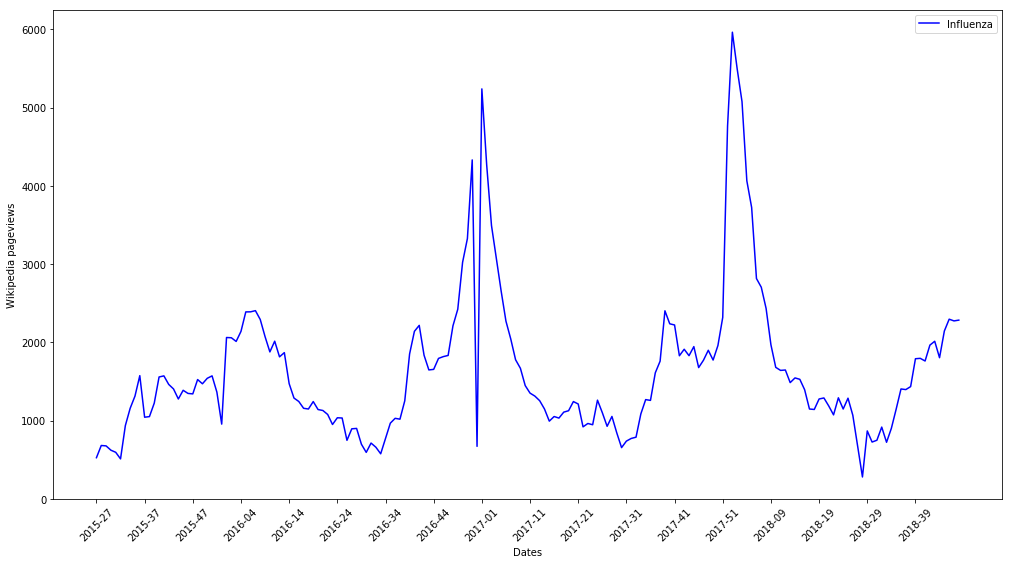

In [6]:
#plot of influenza time series

plotty(df_flu)

### 1.2    
Now, the data from the official InfluNet Surveillance System are collected using **influ_read** function (tramite libreria *PyPDF2*), extracts the data of interest from the pdf files making them *csv* files.

Once obtained the data both from InfluNet and Wikipedia the two time series are compared and visualized; since the InfluNet data are not regarding the whole year, as the wikipedia are, once the two dataframes are concatenated same information (dates) are lost. 

In [7]:
# Creating the Ground Truth (take a bit)
warnings.filterwarnings('ignore')

gt = influ_read('influnet/')

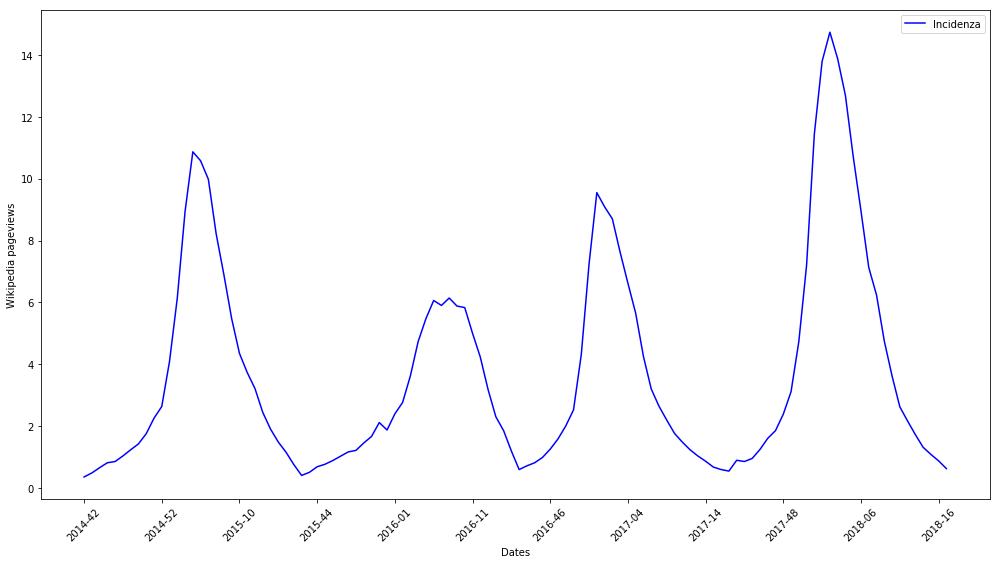

In [8]:
# Plotting our Ground Truth

plotty(gt)

In [9]:
# Concatenating Incidenza (gt) and Influenza (df_flu)

inf_inc_df = pd.concat([df_flu,gt], axis=1).dropna()
inf_inc_df.columns = ["Influenza", "Incidenza"]

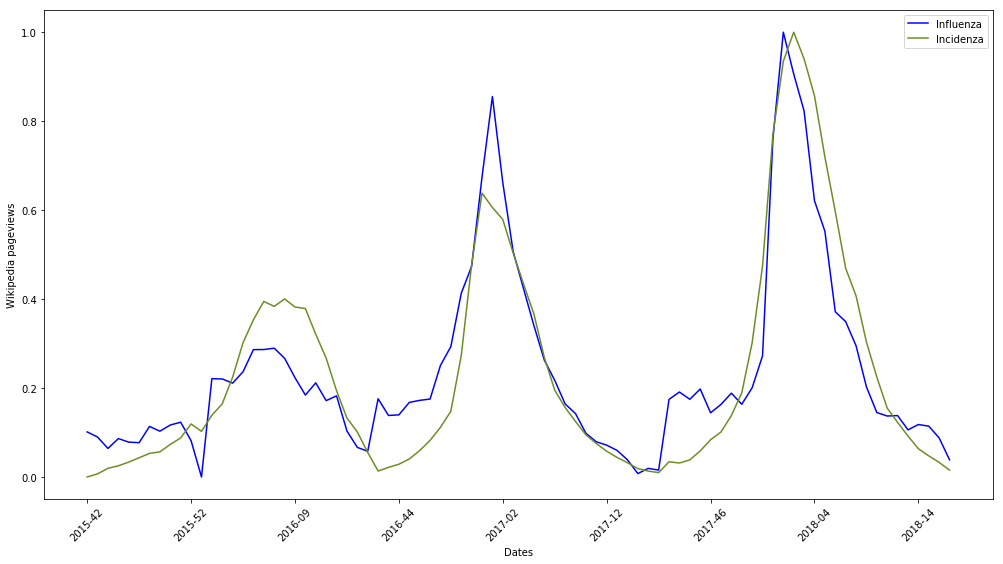

In [10]:
# Scaling data and plotting

inf_inc_df_scaled = inf_inc_df.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
plotty(inf_inc_df_scaled)

The graph shows that the trend of the two variables is similar and that there are peaks and troughs that denote the seasonality of the flu.



Let's see now the correlation.


Correlation (influnet data - influenza pageviews)

----------------------------------
Pearson = 0.9204268926597309
----------------------------------
Spearman = 0.843941580070497
----------------------------------


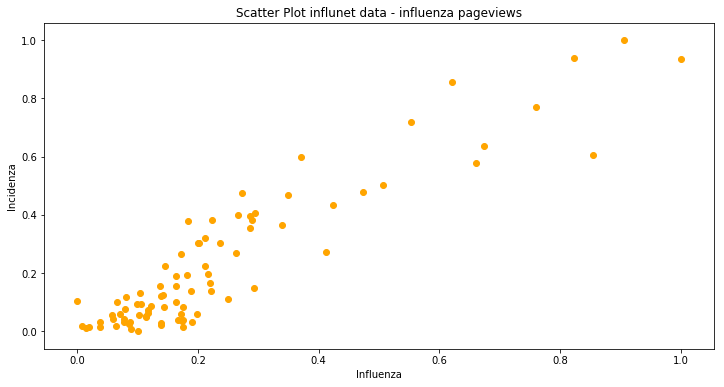

In [11]:
# Pearson and Spearman Correlation

lcor = ['pearson', 'spearman']
print ('\nCorrelation (influnet data - influenza pageviews)\n')
print ('----------------------------------')
for cor in lcor:
    print(cor.capitalize() + ' = ' + str(inf_inc_df['Influenza'].corr(inf_inc_df['Incidenza'], method=cor))) #kendall, pearson, spearman
    print ('----------------------------------')
plt.figure(figsize=(12,6))
plt.scatter(inf_inc_df_scaled['Influenza'], inf_inc_df_scaled['Incidenza'], color = 'orange')
plt.xlabel('Influenza')
plt.ylabel('Incidenza')
plt.title('Scatter Plot influnet data - influenza pageviews')


plt.show()

Pearson's correlation coefficient measures the statistical relationship, or association, between two continuous variables. Spearman's correlation coefficient is the non-parametric version of Pearson's correlation that measures the force and direction of association between two classified variables. Comparing the data from Influnet with the data from the Wikipedia Influence page we see that these coefficients have a strong correlation.

## PART 2

### 2.1

In this part data will be taken (through the function **wikiviews**) and shown the trends about the pages related to the flu, such as symptoms (Febbre, Rinorrea, Mialgia, Cefalea, Vomito), medication such as Paracetamolo and vaccines.

The *wikiviews* function set with the *links* parameter as False, returns only the pageviews of the inserted pagelist.


In [12]:
# Collecting Wikipedia pageviews for the pages related to Influenza and setting the ISO week format

df = wikiviews(pagelist = ['Influenza', 'Febbre', 'Rinorrea', 'Mialgia', 'Cefalea', 'Vomito', 'Paracetamolo', 
                           'Vaccino_antinfluenzale'], links = False)


In [13]:
# Adding incidenza values to the DataFrame

data = pd.concat([df,gt], axis=1).dropna()
data.head()

,Influenza,Febbre,Rinorrea,Mialgia,Cefalea,Vomito,Paracetamolo,Vaccino_antinfluenzale,Incidenza
2015-42,1464.0,3375.0,524.0,1129.0,2322.0,1728.0,6360.0,591.0,0.40
2015-43,1406.0,3363.0,462.0,1016.0,2292.0,1638.0,6291.0,633.0,0.50
2015-44,1278.0,3190.0,417.0,967.0,2323.0,1817.0,5965.0,693.0,0.68
2015-45,1389.0,3345.0,494.0,1053.0,2556.0,1854.0,6107.0,859.0,0.76
2015-46,1349.0,3142.0,402.0,1054.0,2546.0,1929.0,5850.0,924.0,0.88


In [14]:
# Scale the data for a better visualization and comparison
data_scaled = data.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))

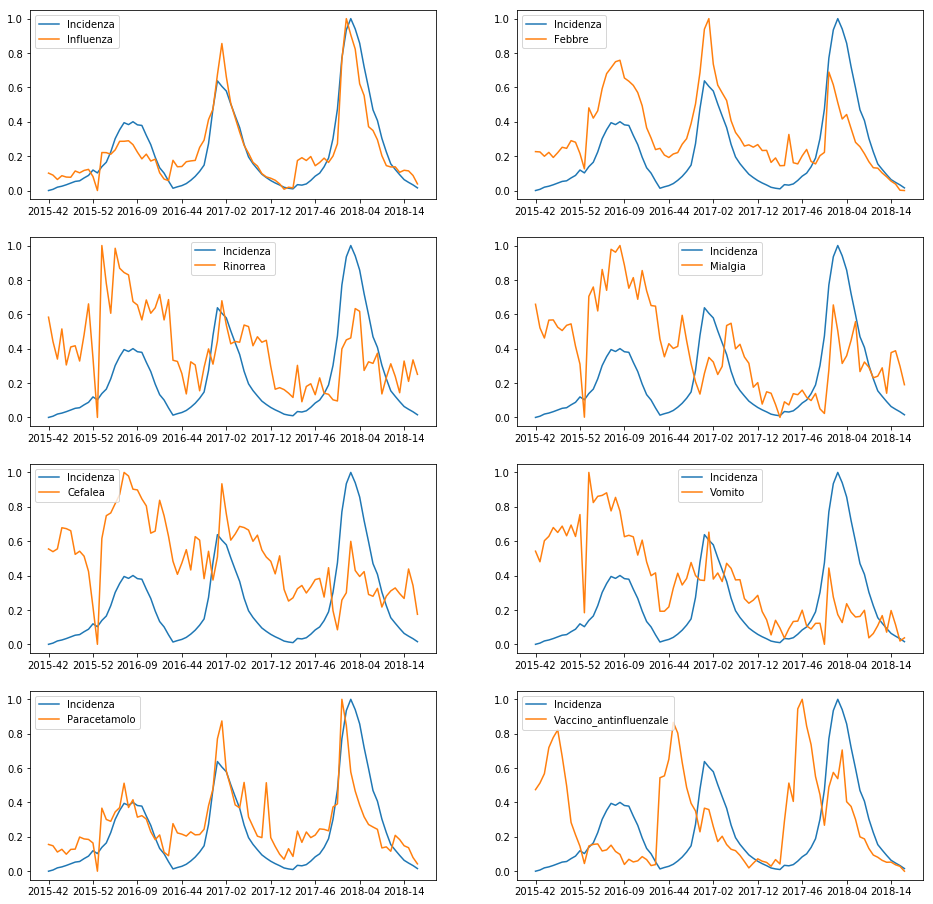

In [15]:
# Plot trend between each pagelist's element and the goundtruth (Incidenza)
i = 1

for page in data_scaled.iloc[:,:-1].columns:
    plt.rcParams['figure.figsize'] = 16, 16
    plt.subplot(4,2,i)
    gsb = pd.concat((data_scaled['Incidenza'],data_scaled[page]),axis=1)
    plt.plot(gsb)
    plt.xticks(gsb.index[0::10])
    plt.legend(gsb)

    i += 1
    
plt.show()

Through these plots you can see which variables have a trend more similar to our groundthruth, that is, the Incidenza. 

The closest pages seem to be: Influenza, Febbre and Paracetamolo. 
This denotes how actually sick subjects tend to search on wikipedia for their symptoms and / or any medications.

##### ...how did we get other pages?

In the function **wikiviews** setting the parameter *links* as True is possible to find all the links of the pages contained in the *pagelist*, ie the list of words just analyzed. In this way a larger dataset of about 1000 words is created, with the aim of finding other informative words at least as much as Influenza, Febbre and Paracetamolo are.

In [16]:
# Creating new DataFramw switching links parameter to True [takes 5 min ca]

import time
a=time.time()

final_df = wikiviews(['Influenza','Febbre','Rinorrea', 'Mialgia', 'Cefalea', 'Vomito', 'Paracetamolo', 
                      'Vaccino_antinfluenzale'], True)
time.time()-a

243.7230191230774

In the next section these new data will be analyzed and new discoveries made.

### 2.2

In this section we will analyze the possible correlation between the new and the previous pages.

In [17]:
# Execute the correlation for the first set of pages.

correlation=pd.DataFrame(data.corr().iloc[-1,:-1])
correlation

,Incidenza
Influenza,0.920427
Febbre,0.647259
Rinorrea,0.294959
Mialgia,0.156213
Cefalea,0.107998
Vomito,0.029459
Paracetamolo,0.769443
Vaccino_antinfluenzale,0.012908


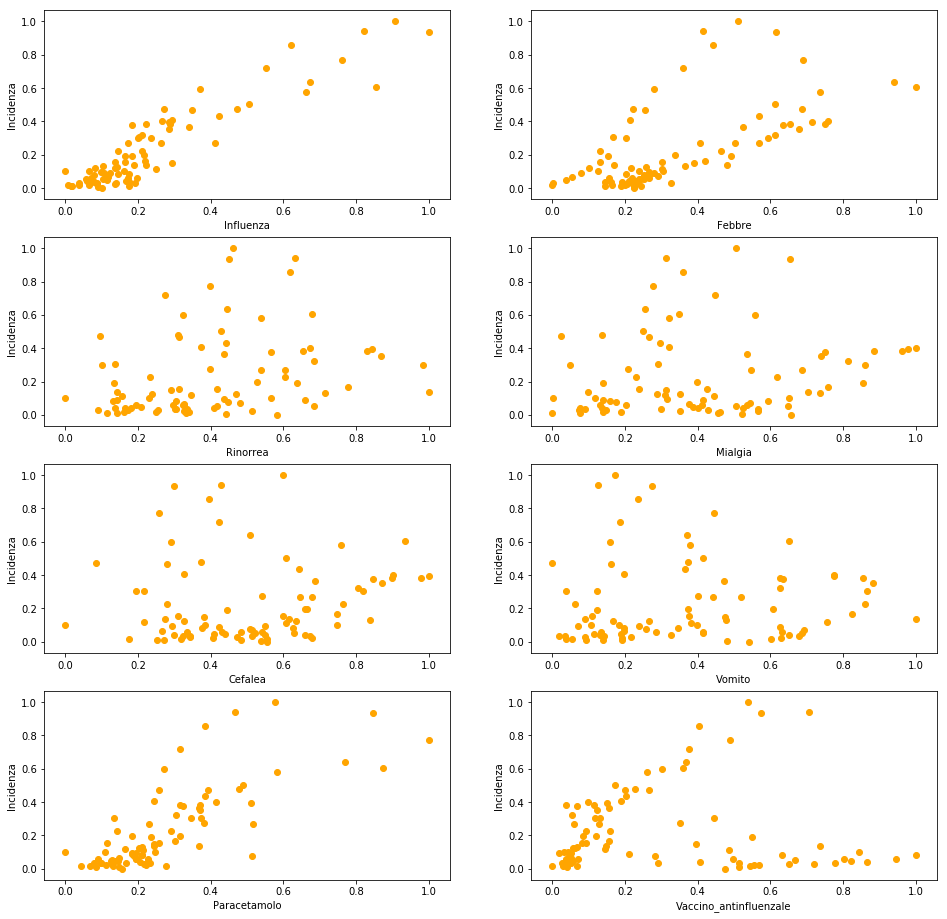

In [18]:
# Make a Scatter Plot series for all the variables.
i = 1

for elem in data_scaled.iloc[:, :-1].columns:
    
    plt.rcParams['figure.figsize'] = 16, 16
    plt.subplot(4, 2, i)

    plt.scatter(data_scaled[str(elem)], data_scaled['Incidenza'], color = 'orange')

    plt.xlabel(str(elem))
    plt.ylabel('Incidenza')
    
    i +=1
    
plt.show()

Our new DataFrame presents the first 10 new pages with the highest correlation with respect to Incidenza.

In [19]:
# Execute the correlation for the new set of pages.

final_df_new = pd.concat((gt,final_df), axis=1).dropna()

supercorr=final_df_new.corr()['Incidenza'].sort_values(ascending=False)
pd.DataFrame(supercorr[1:11])

,Incidenza
Oseltamivir,0.919142
Influenzavirus A,0.893986
Pandemia influenzale,0.862025
Influenza asiatica,0.855785
Avvelenamento da paracetamolo,0.834972
Influenza di Hong Kong,0.804240
Zanamivir,0.797704
Antipiretico,0.776005
Antibiotico,0.755693
Polmonite,0.753689


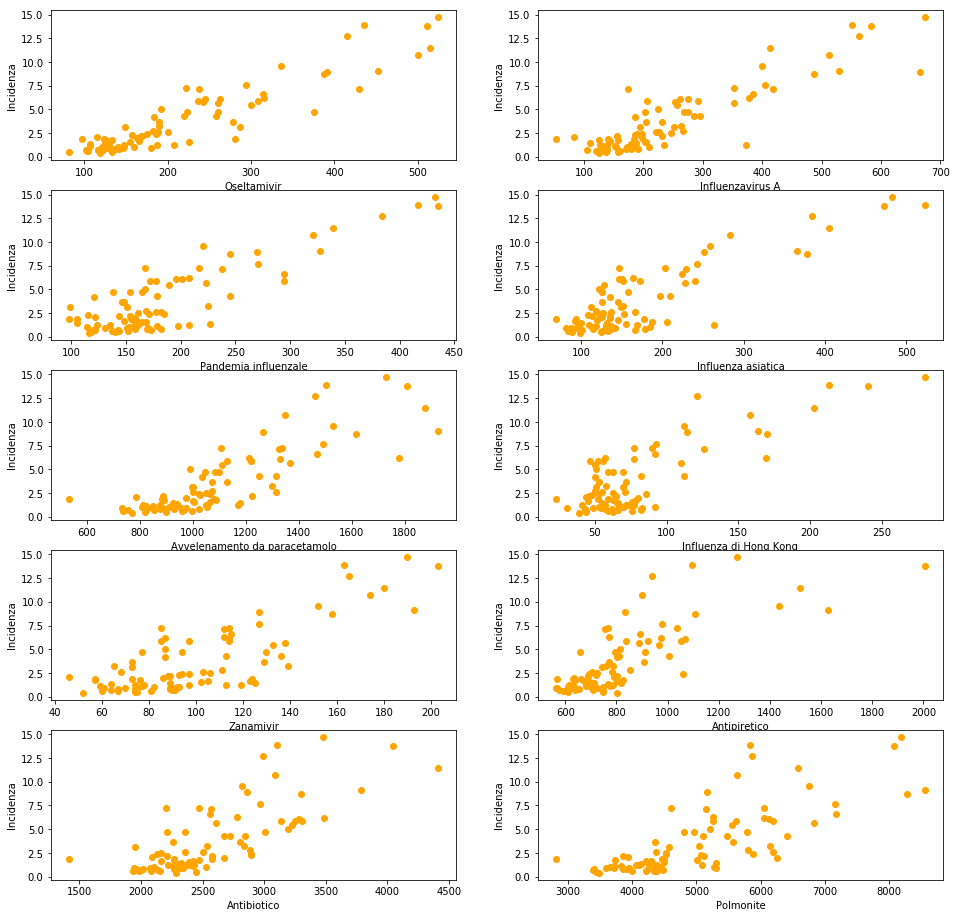

In [20]:
# Make a Scatter Plot series for all the variables.

i = 1

for elem in supercorr[1:11].index:
    
    plt.rcParams['figure.figsize'] = 16, 16
    plt.subplot(5, 2, i)
    plt.scatter(final_df_new[elem], final_df_new['Incidenza'], color = 'orange')
    plt.xlabel(elem)
    plt.ylabel('Incidenza')   
    i +=1  
plt.show()

In [21]:
# DataFrame with the most correlated pages and Incidenza

data_10 = final_df_new[supercorr[:11].index]
data_10.head()

,Incidenza,Oseltamivir,Influenzavirus A,Pandemia influenzale,Influenza asiatica,Avvelenamento da paracetamolo,Influenza di Hong Kong,Zanamivir,Antipiretico,Antibiotico,Polmonite
2015-42,0.40,119.0,125.0,116.0,98.0,771.0,39.0,52.0,801.0,2282.0,3480.0
2015-43,0.50,82.0,158.0,118.0,89.0,821.0,44.0,75.0,747.0,2443.0,3447.0
2015-44,0.68,102.0,136.0,122.0,85.0,757.0,43.0,64.0,707.0,2138.0,3390.0
2015-45,0.76,123.0,139.0,120.0,131.0,828.0,62.0,74.0,745.0,2266.0,3924.0
2015-46,0.88,127.0,135.0,131.0,93.0,733.0,31.0,90.0,723.0,2344.0,3597.0


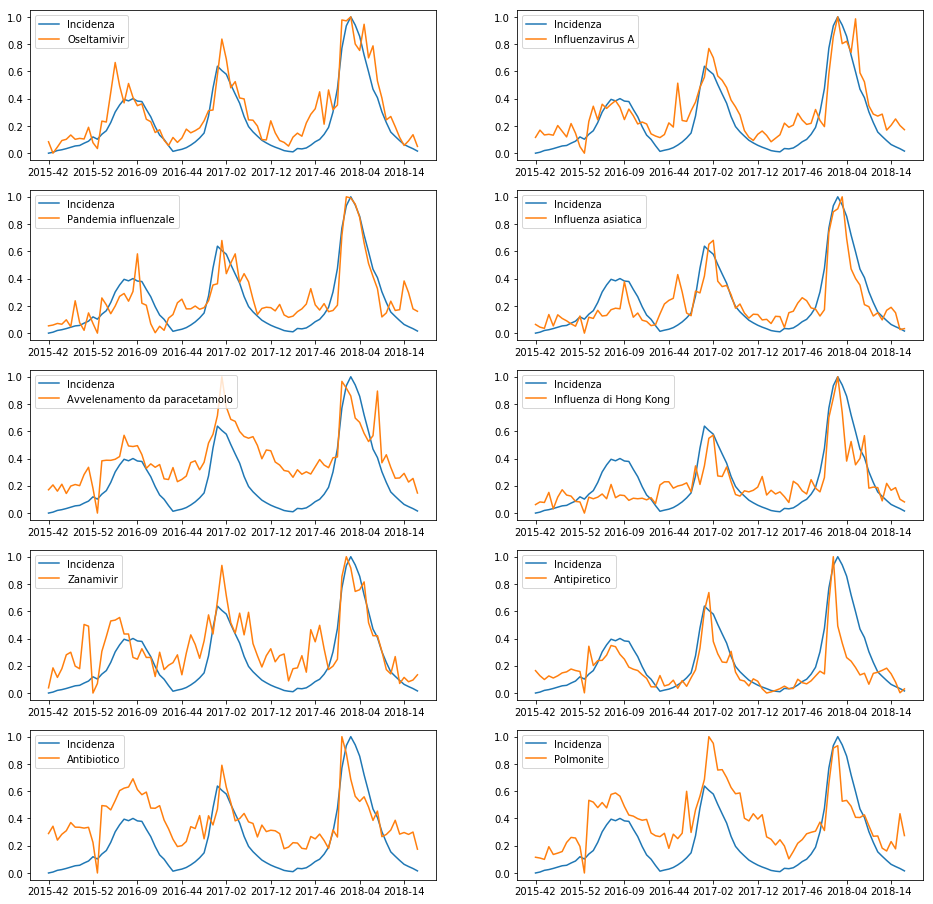

In [23]:
# Plot trend between each pagelist's element and the goundtruth (Incidenza)
data10_scaled = data_10.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))

i = 1
for page in data10_scaled.iloc[:,1:].columns:
    plt.rcParams['figure.figsize'] = 16, 16
    plt.subplot(5,2,i)
    gsb = pd.concat((data10_scaled['Incidenza'],data10_scaled[page]),axis=1)
    plt.plot(gsb)
    plt.xticks(gsb.index[0::10])
    plt.legend(gsb)
    i += 1    
plt.show()

Also from these plots you can see the high correlation that these new pages present. 

The most correlated are: 
-  Oseltamivir 
-  InfluenzaVirusA
-  PandemiaInfluenzale

## PART 3

### 3.1

The dataset that will be used in this task contains the ten most correlated page with Incidenza founded above and common word related only to Influenza.


In [24]:
# Concatenate the most correlated pages in a DataFrame

df_concat = pd.concat((data_10,data.iloc[:,:-1]), axis = 1)
df_concat.head()

,Incidenza,Oseltamivir,Influenzavirus A,Pandemia influenzale,Influenza asiatica,Avvelenamento da paracetamolo,Influenza di Hong Kong,Zanamivir,Antipiretico,Antibiotico,Polmonite,Influenza,Febbre,Rinorrea,Mialgia,Cefalea,Vomito,Paracetamolo,Vaccino_antinfluenzale
2015-42,0.40,119.0,125.0,116.0,98.0,771.0,39.0,52.0,801.0,2282.0,3480.0,1464.0,3375.0,524.0,1129.0,2322.0,1728.0,6360.0,591.0
2015-43,0.50,82.0,158.0,118.0,89.0,821.0,44.0,75.0,747.0,2443.0,3447.0,1406.0,3363.0,462.0,1016.0,2292.0,1638.0,6291.0,633.0
2015-44,0.68,102.0,136.0,122.0,85.0,757.0,43.0,64.0,707.0,2138.0,3390.0,1278.0,3190.0,417.0,967.0,2323.0,1817.0,5965.0,693.0
2015-45,0.76,123.0,139.0,120.0,131.0,828.0,62.0,74.0,745.0,2266.0,3924.0,1389.0,3345.0,494.0,1053.0,2556.0,1854.0,6107.0,859.0
2015-46,0.88,127.0,135.0,131.0,93.0,733.0,31.0,90.0,723.0,2344.0,3597.0,1349.0,3142.0,402.0,1054.0,2546.0,1929.0,5850.0,924.0


To build our model as first thing we have to choose which one would be suitable for our data. 

Let's have a look to the correlation between the dependent variables.

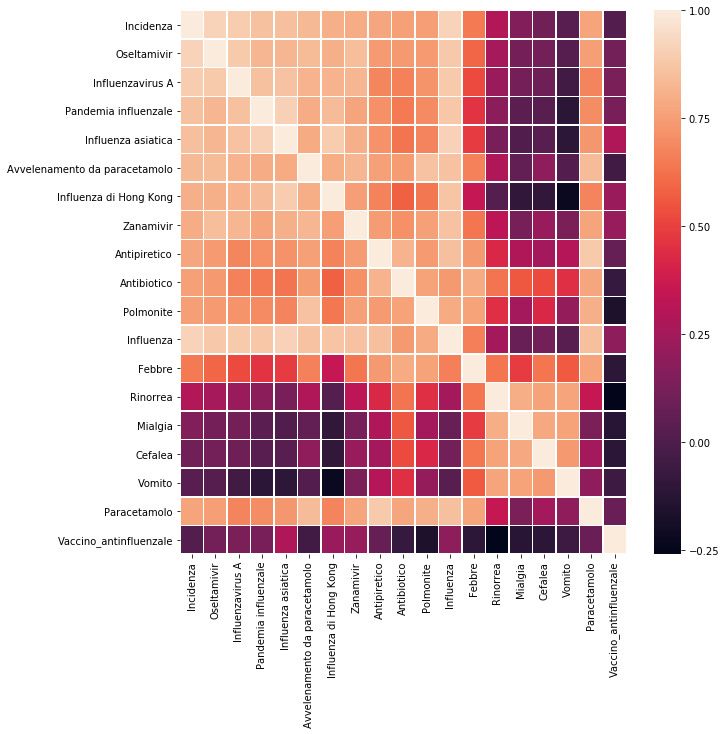

In [25]:
plt.rcParams['figure.figsize'] = 10, 10
ax = sns.heatmap(df_concat.corr(), linewidths=.5)

As a matter of fact there are more than half features highly correlated between each other. For this reason we decided to use models that are robust to multicollinearity sush as: 
-  Lasso
-  Ridge

The data are splitted in two parts, 70% and 30% respectively; the first is used to fit the model (Train) and the latter to test the results of the model predictions.

In [26]:
# Split train and test

train, test, y_train, y_test = model_selection.train_test_split(
    df_concat[df_concat.columns[1:]], df_concat['Incidenza'], test_size = 0.3, random_state=666)

## Lasso model

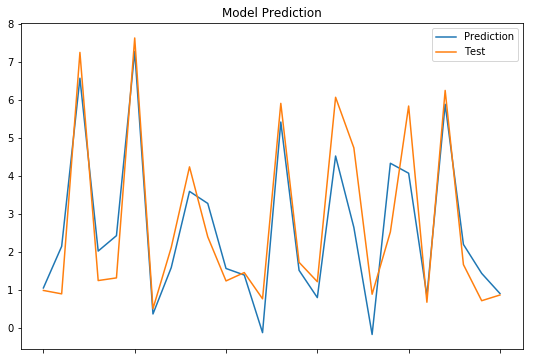

R-Squared: 0.9538572299049513
RMSE: 0.9210403771448632


In [27]:
# Training and plotting LassoCV model

model = LassoCV(n_alphas=1000, cv=10, random_state=666, n_jobs=4).fit(train, y_train)
y_pred = model.predict(test)

plt.rcParams['figure.figsize'] = 9, 6

first_m = pd.DataFrame({'Prediction' : y_pred, 'Test': y_test}).plot()
first_m.plot()
plt.title('Model Prediction')

plt.show()

print('R-Squared: ' + str(model.score(train, y_train)))
print('RMSE: ' + str(np.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred))))



## Ridge model

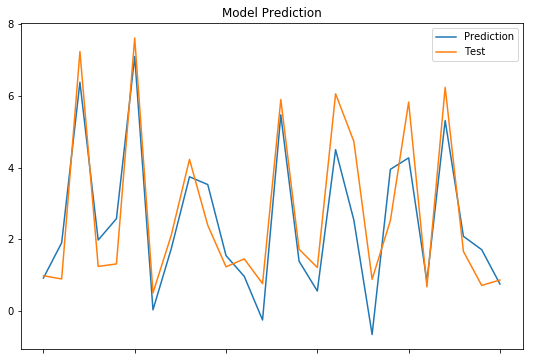

R-Squared: 0.9573422473908314
RMSE: 0.9671702655184703


In [28]:
# Training and plotting RidgeCV model

model = RidgeCV().fit(train, y_train)
y_pred = model.predict(test)

plt.rcParams['figure.figsize'] = 9, 6

second_m = pd.DataFrame({'Prediction' : y_pred, 'Test': y_test}).plot()
second_m.plot()
plt.title('Model Prediction')

plt.show()

print('R-Squared: ' + str(model.score(train, y_train)))
print('RMSE: ' + str(np.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred))))



Both models give good results in terms of R-squared (a measure of how a model explains the variability of the target variables) and Root Mean Squared Error.

### 3.2

Trying to get better results we add as features the data of the week preceding the target week for all the variables we already had, and fit the same models again.

In [29]:
# Create a new DataFrame with shifted values

shifted = df_concat.shift(1)
shifted.columns = [col + ' -' + str(1) for col in df_concat.columns]

new_data = pd.concat([df_concat.iloc[1:], shifted[1:]], axis = 1)
new_data.head()

,Incidenza,Oseltamivir,Influenzavirus A,Pandemia influenzale,Influenza asiatica,Avvelenamento da paracetamolo,Influenza di Hong Kong,Zanamivir,Antipiretico,Antibiotico,...,Antibiotico -1,Polmonite -1,Influenza -1,Febbre -1,Rinorrea -1,Mialgia -1,Cefalea -1,Vomito -1,Paracetamolo -1,Vaccino_antinfluenzale -1
2015-43,0.50,82.0,158.0,118.0,89.0,821.0,44.0,75.0,747.0,2443.0,...,2282.0,3480.0,1464.0,3375.0,524.0,1129.0,2322.0,1728.0,6360.0,591.0
2015-44,0.68,102.0,136.0,122.0,85.0,757.0,43.0,64.0,707.0,2138.0,...,2443.0,3447.0,1406.0,3363.0,462.0,1016.0,2292.0,1638.0,6291.0,633.0
2015-45,0.76,123.0,139.0,120.0,131.0,828.0,62.0,74.0,745.0,2266.0,...,2138.0,3390.0,1278.0,3190.0,417.0,967.0,2323.0,1817.0,5965.0,693.0
2015-46,0.88,127.0,135.0,131.0,93.0,733.0,31.0,90.0,723.0,2344.0,...,2266.0,3924.0,1389.0,3345.0,494.0,1053.0,2556.0,1854.0,6107.0,859.0
2015-47,1.02,141.0,179.0,114.0,130.0,809.0,53.0,93.0,746.0,2524.0,...,2344.0,3597.0,1349.0,3142.0,402.0,1054.0,2546.0,1929.0,5850.0,924.0


## Lasso model

In [30]:
# Split train and test

train, test, y_train, y_test = model_selection.train_test_split(
    new_data[new_data.columns[1:]], new_data['Incidenza'], test_size = 0.30, random_state=666)

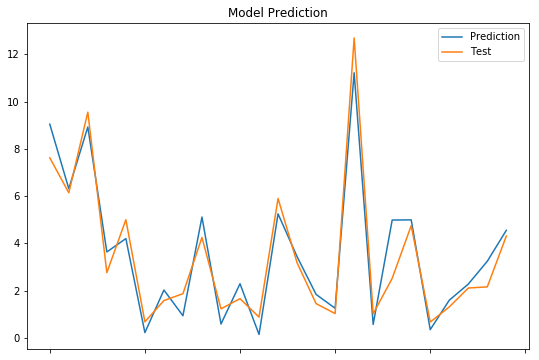

R-Squared: 0.9647296534343173
RMSE: 0.8454980847975375


In [31]:
# Training and plotting LassoCv model

model = LassoCV(n_alphas=1000, cv=10, random_state=666, n_jobs=4).fit(train, y_train)
y_pred = model.predict(test)


plt.rcParams['figure.figsize'] = 9, 6

third_m = pd.DataFrame({'Prediction' : y_pred, 'Test': y_test}).plot()
third_m.plot()
plt.title('Model Prediction')

plt.show()

print('R-Squared: ' + str(model.score(train, y_train)))
print('RMSE: ' + str(np.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred))))

## Ridge model

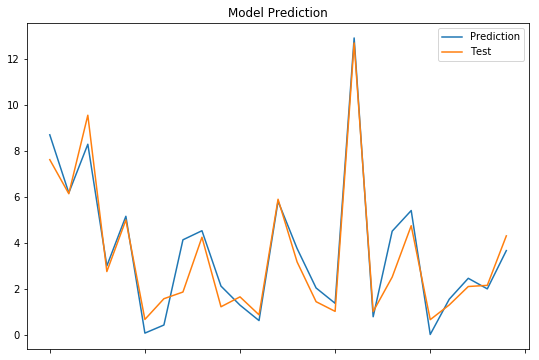

R-Squared: 0.9909932317408955
RMSE: 0.8268408386829006


In [32]:
model = RidgeCV(cv = 5).fit(train, y_train)
y_pred = model.predict(test)

plt.rcParams['figure.figsize'] = 9, 6

fourth_m = pd.DataFrame({'Prediction' : y_pred, 'Test': y_test}).plot()
fourth_m.plot()
plt.title('Model Prediction')

plt.show()

print('R-Squared: ' + str(model.score(train, y_train)))
print('RMSE: ' + str(np.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred))))


Despite results are almost the same using the Lasso model, an improvement can be seen for the Ridge model.

This analysis can show that is possible to predict with good accuracy the influenza's incidence, using Wikipedia pageviews, in Italy. The best model is the Ridge model considering the week preceding the target week. 

Even if the analyzed period and the population taken into account are different, it is possible to compare our results with the one of McIver and Brownstein in terms of RMSE; they reach an RMSE = 0.27, while our best model's RMSE is 0.82 . 
